# Projeto: Análise e Predição de Churn de acordo com o perfil de clientes



<p align="center">
  <img src="telco.jpeg" >
</p>



**Churn é um grande problema para empresas de telecomunicação**. Com concorrência acirrada, adoção de novas (e custosas) tecnologias e altos custos de manutenção manter sua base de clientes é primordial para se manter relevante no mercado. Saber quais clientes podem deixar de assinar seus serviços pode evitar um churn em massa que pode desestabilizar suas operações.


Este projeto usa uma base de dados disponibilizada no [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn?select=WA_Fn-UseC_-Telco-Customer-Churn.csv) e visa analizar os clientes de uma empresa fictícia de telecom usando as várias técnicas aprendidas no curso de MBA de Data Science and Analytics do PECEGE - USP. 

As técnicas que pretendo usar aqui são:

- Análise Exploratória de Dados
- Arvore de Decisão
- Floresta de Decisão
- Logistica Binaria

Para começar, vamos estudar nossos dados vendo suas características.

Temos uma base de dados com 7043 linhas e 21 colunas distintas:
- Customer ID: Identificação de clientes, todas linhas únicas.
- Gender: Genero biológico da pessoa (Homem ou Mulher)
- SeniorCitizen: Se a pessoa é idosa (0 para não 1 para sim)
- Partner: Se a pessoa tem um parceiro/a (0 para não 1 para sim)
- Dependents: Se a pessoa tem dependentes (Yes or No)
- Tenure: A quantos meses o cliente é assinante
- PhoneService: Se a pessoa tem serviço de telefone ou não (Yes or No)
- Multiple Lines: Se a pessoa tem mais de uma linha (Yes, No or No Phone Service)
- Internet Service: Se a pessoa assina internet (DSL, Fiber Optic, No)
- OnlineSecurity: se ela assina o serviço de segurança online (Yes, No, No internet service)
- OnlineBackup: Se o cliente tem serviço de backup online (Yes, No, No internet service)
- DeviceProtection: Se o cliente tem proteção para seu dispositivo (Yes, No, No internet service)
- TechSupport: Se o cliente assina o suporte técnico (Yes, No, No internet service)
- StreamingTV: Se o cliente assina o serviço de streaming de TV (Yes, No, No internet service)
- StreamingMovies: Se o cliente assina o serviço de streaming de filmes (Yes, No, No internet service)
- Contract: Qual o tipo de contrato o cliente tem (mês a mês, um ano, dois anos)
- Paperless Billing: Se o cliente optou por faturas eletrônicas (Yes or No)
- PaymentMethod: Método de pagamento ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)')
- MonthCharges: Custos mensais do cliente
- TotalCharges: Custos totais do cliente
- Churn: Se o cliente saiu da empresa ou não, nossa variável alvo

Vamos dar uma olhada no resumo desses dados


In [1]:
import pandas as pd
import csv
import collections, numpy

df = pd.read_csv('churn.csv')

print(df.head())
df.describe()
df['Contract'].unique()
#df['PaymentMethod'].unique()

# A coluna TotalCharges está como string, vou substituir valores nulos ou vazios por 0 e converter para float.
df['TotalCharges'].replace([' ','',' '],0,inplace=True)
df['TotalCharges'] = df['TotalCharges'].astype({'TotalCharges': float})


#print('\nPorcentagem de Homens: %', (df['gender'].value_counts()[0]*100)/df['gender'].count())
#print('\nPorcentagem de Idosos: %', (df['SeniorCitizen'].value_counts()[1]*100)/df['SeniorCitizen'].count())
#print('\nPorcentagem de Pessoas com Parceiros: %', (df['Partner'].value_counts()[1]*100)/df['Partner'].count())
#print('\nPorcentagem de Pessoas com Dependentes: %', (df['Dependents'].value_counts()[1]*100)/df['Dependents'].count())
#print('\nPorcentagem de Churn: %', (df['Churn'].value_counts()[1]*100)/df['Churn'].count())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

Não temos linhas sem valores, então não precisamos remediar isso na nossa base de dados.
Vamos ver a distribuição de valores de nossas variáveis por meio de histogramas.

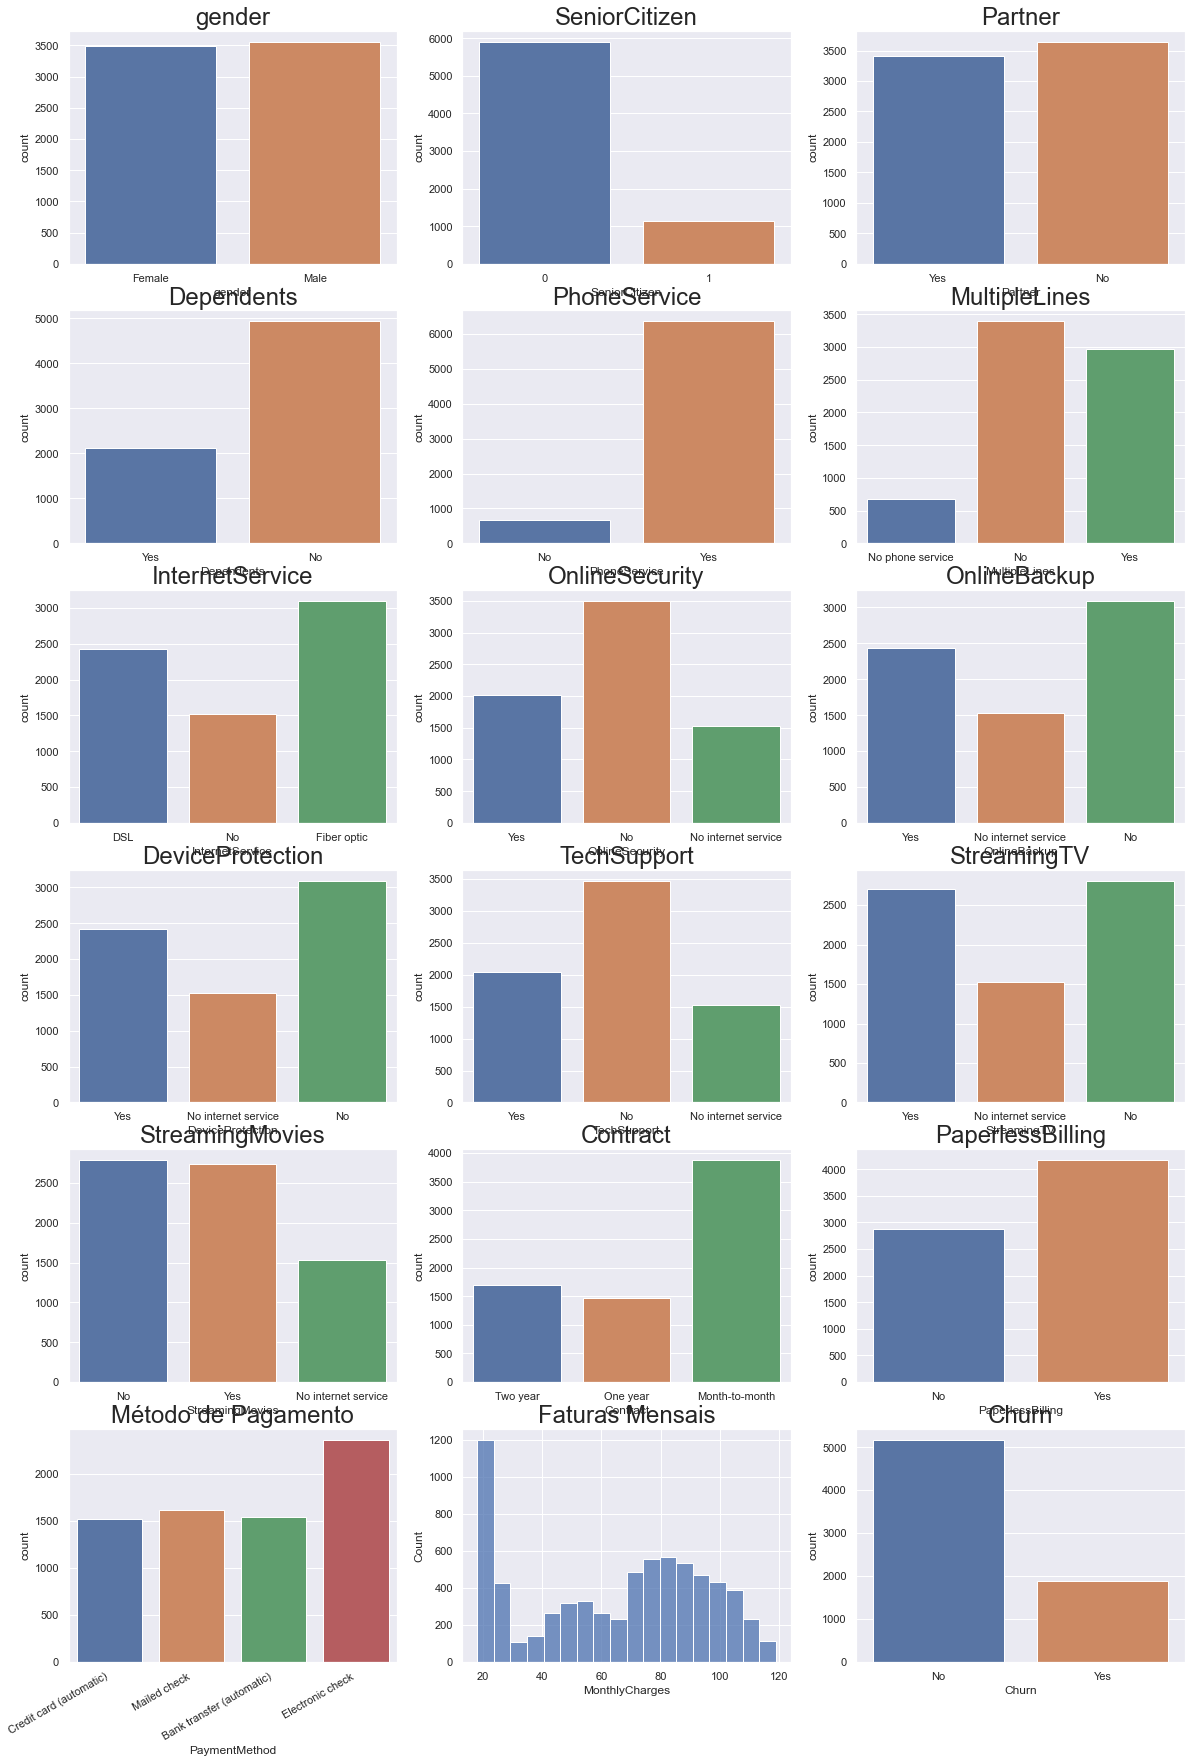

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

fig , ax = plt.subplots(nrows = 6, ncols = 3)
variaveis = ['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
'StreamingMovies','Contract','PaperlessBilling','PaymentMethod']

i=0
j=0

for variavel in variaveis:
    sns.countplot(data = df, x = variavel, ax=ax[i][j])
    ax[i][j].set_title(variavel,fontdict= {'fontsize': 24})
    j = j + 1
    if j > 2:
        j = 0
        i = i + 1


sns.countplot(data = df, x = 'PaymentMethod', ax=ax[5][0])
labels = df['PaymentMethod'].unique()
ax[5][0].set_title('Método de Pagamento',fontdict= {'fontsize': 24})
ax[5][0].set_xticklabels(labels,rotation=30, ha= 'right')
sns.histplot(data = df, x = 'MonthlyCharges', ax=ax[5][1])
ax[5][1].set_title('Faturas Mensais',fontdict= {'fontsize': 24})
sns.countplot(data = df, x = 'Churn', ax=ax[5][2])
ax[5][2].set_title('Churn',fontdict= {'fontsize': 24})

sns.set(rc={'figure.figsize':(20,30)})

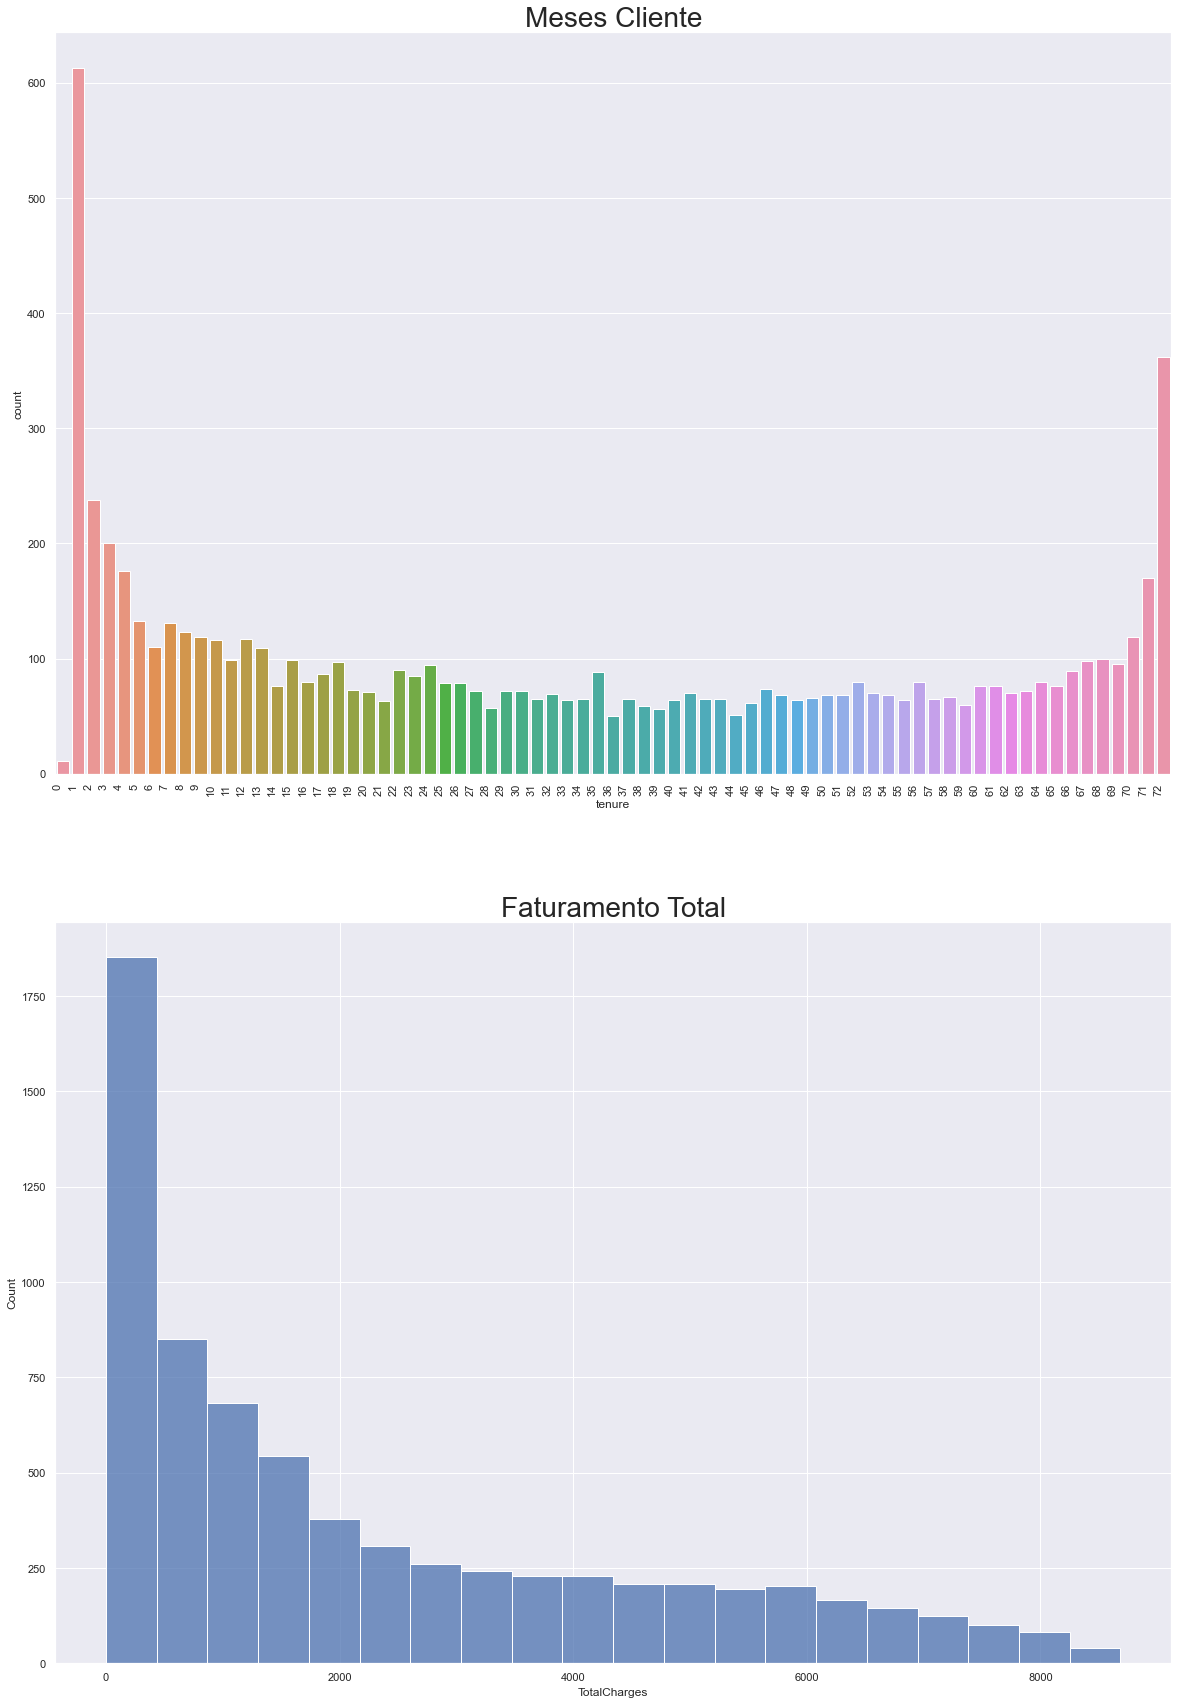

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.sort_values(['tenure']).reset_index(drop=True)

fig , ax = plt.subplots(nrows = 2, ncols = 1)
sns.countplot(data = df, x = 'tenure', ax=ax[0])
ax[0].set_title('Meses Cliente',fontdict= {'fontsize': 28})
sns.histplot(data = df, x = 'TotalCharges', ax=ax[1], bins = 20)
ax[1].set_title('Faturamento Total',fontdict= {'fontsize': 28})

labels = df['tenure'].unique()
ax[0].set_xticklabels(labels,rotation = 90, ha= 'right')


sns.set(rc={'figure.figsize':(50,35)},font_scale=2)

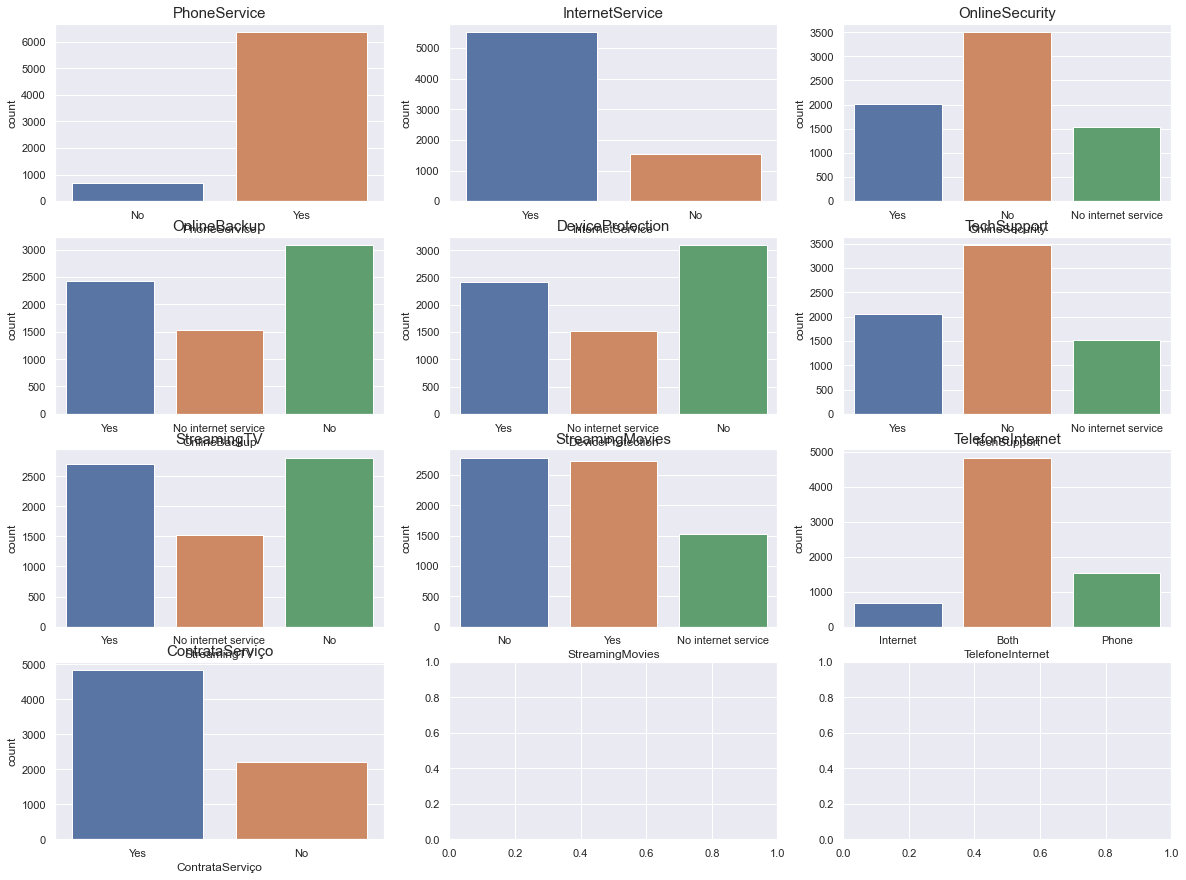

In [21]:

import seaborn as sns
import matplotlib.pyplot as plt

produtos = df.copy(deep=True)
produtos = produtos.replace(['DSL','Fiber optic'],'Yes')

def internet_e_telefone(row):
    if row['InternetService'] == 'Yes' and row['PhoneService'] == 'Yes':
        val = 'Both'
    if row['InternetService'] == 'No' and row['PhoneService'] == 'Yes':
        val = 'Phone'
    if row['InternetService'] == 'Yes' and row['PhoneService'] == 'No':
        val = 'Internet'
    return val

def servico_extra(row):
    val = 'No'
    if row['OnlineSecurity'] == 'Yes' or row['OnlineBackup'] == 'Yes' or row['DeviceProtection'] == 'Yes' or row['TechSupport'] == 'Yes' or row['StreamingTV'] == 'Yes' or row['StreamingMovies'] == 'Yes':
        val = 'Yes'
    return val


produtos['TelefoneInternet'] = produtos.apply(internet_e_telefone,axis=1)
produtos['ContrataServiço'] = produtos.apply(servico_extra,axis=1)


fig , ax = plt.subplots(nrows = 4, ncols = 3)
font_size = 15

i=0
j=0

variaveis = ['PhoneService','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','TelefoneInternet','ContrataServiço']


for variavel in variaveis:
    sns.countplot(data = produtos, x = variavel, ax=ax[i][j])
    ax[i][j].set_title(variavel,fontdict= {'fontsize': font_size})
    j = j + 1
    if j > 2:
        j = 0
        i = i + 1



sns.set(rc={'figure.figsize':(20,15)})

Temos muitos dados interessantes em nossa base! É possível tirar vários insights!


Para melhor organizar as idéias, vamos usar bullet points:
- Os assinantes do serviço são homens, porém com uma pequena margem de vantagem (50,48% de homens);
- Uma pequena parcela dos assinantes são idosos (16%);
- Quase metade dos assinantes tem parceiros (48%);
- Os assinantes com dependentes fazem 30% da base de clientes.
- O serviço de telefonia é o produto mais popular;
- A maioria das pessoas assina a internet e o serviço de telefonia simultâneamente;
- Dos que contratam o serviço de Internet, a grande maioria contrata serviços adicionais como Streaming, Backup Online, etc...
- O serviço mais popular é o de Streaming de TV e Filmes e o menos popular é o de Segurança Online;
- Pelo gráfico de __tenure__ podemos ver que a maioria dos clientes da empresa são recém chegados ou já assinam seus produtos a mais de 71 meses;
- Tivemos um Churn de **26%** neste mês, ou seja, 1/4 de nossa base de clientes foi embora em um mês!!


Nessa próxima parte vamos analisar qual a porcentagem de churn para cada grupo de clientes.

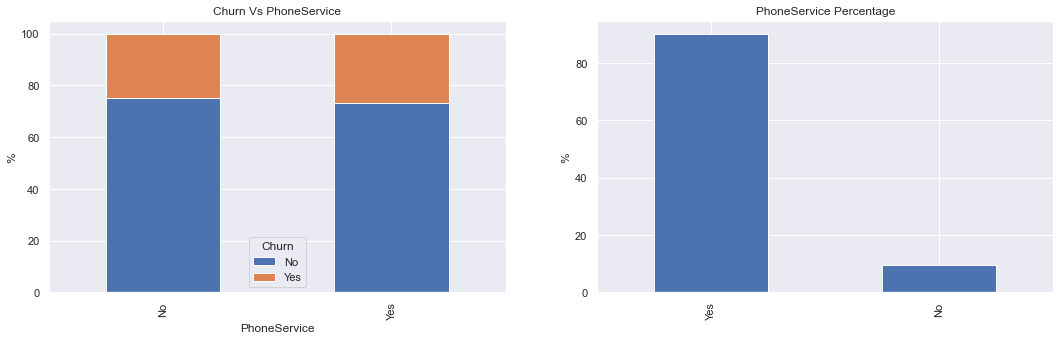

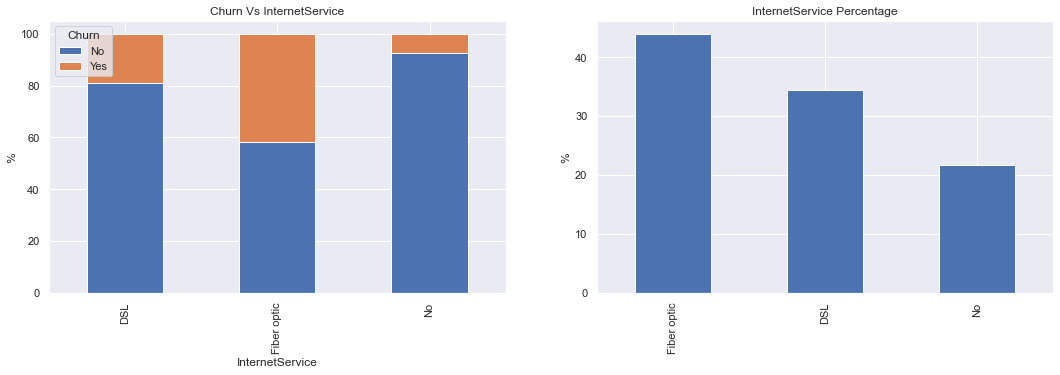

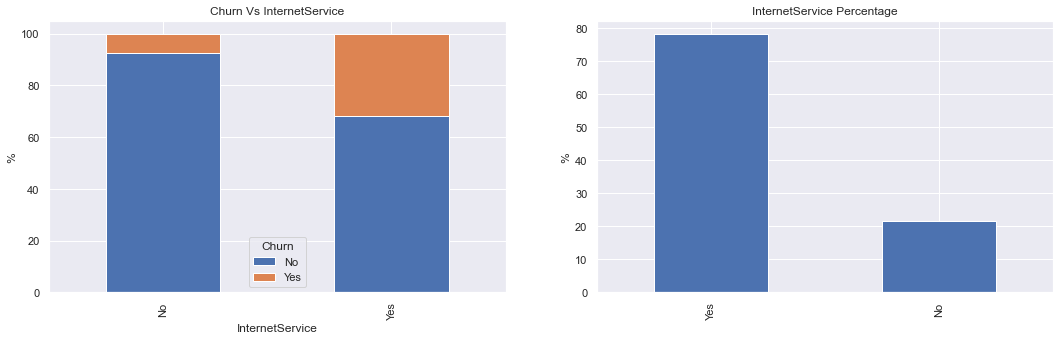

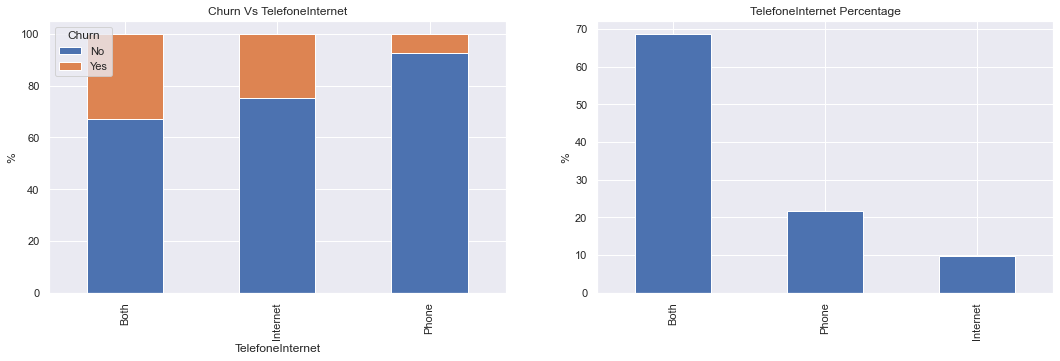

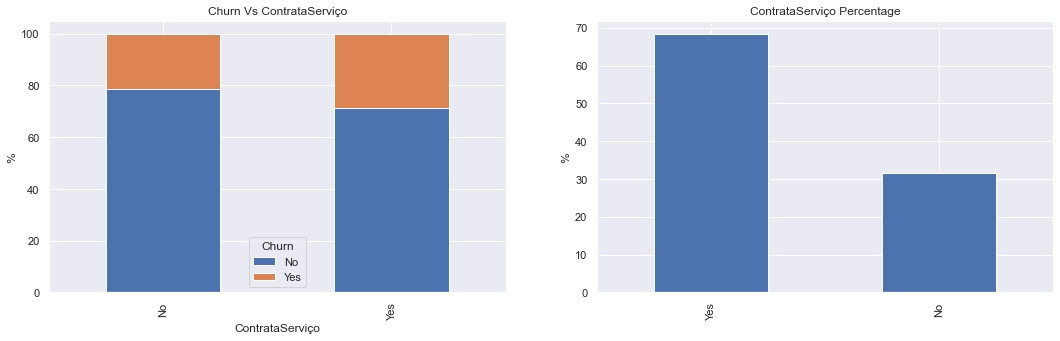

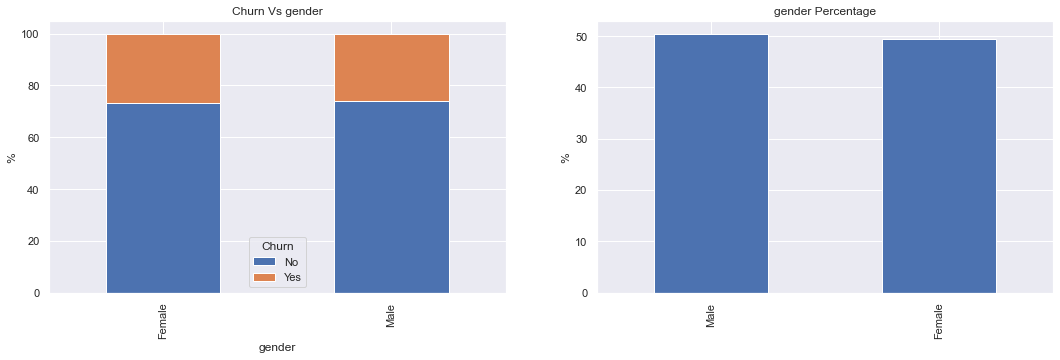

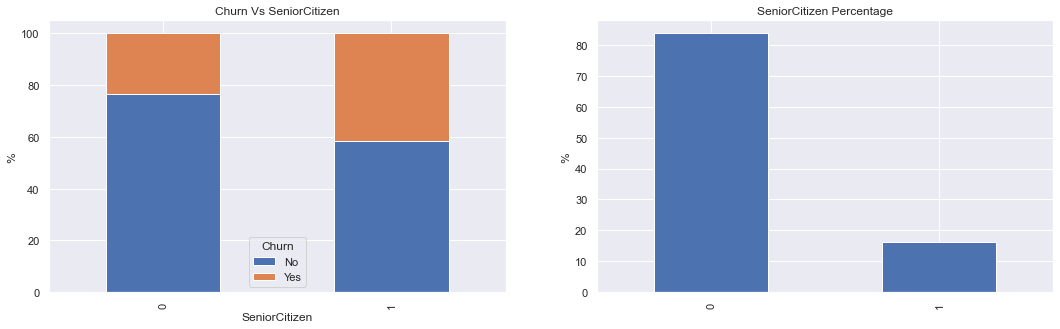

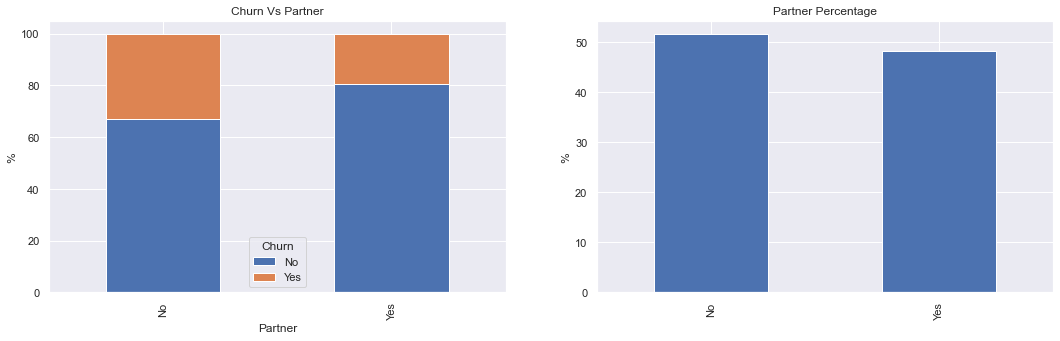

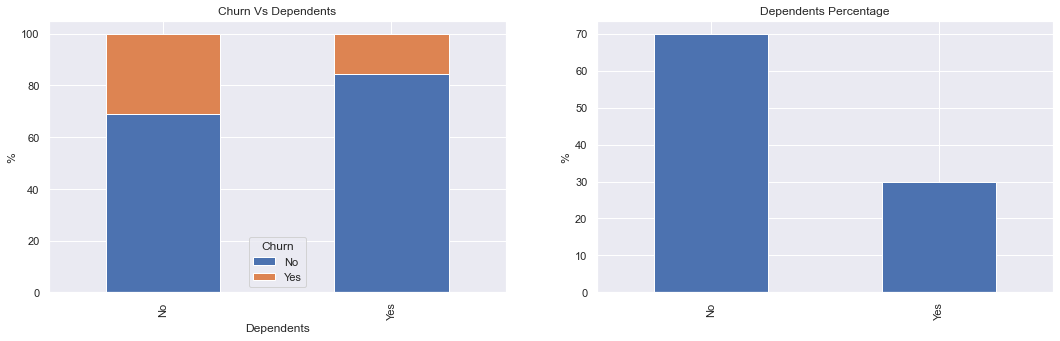

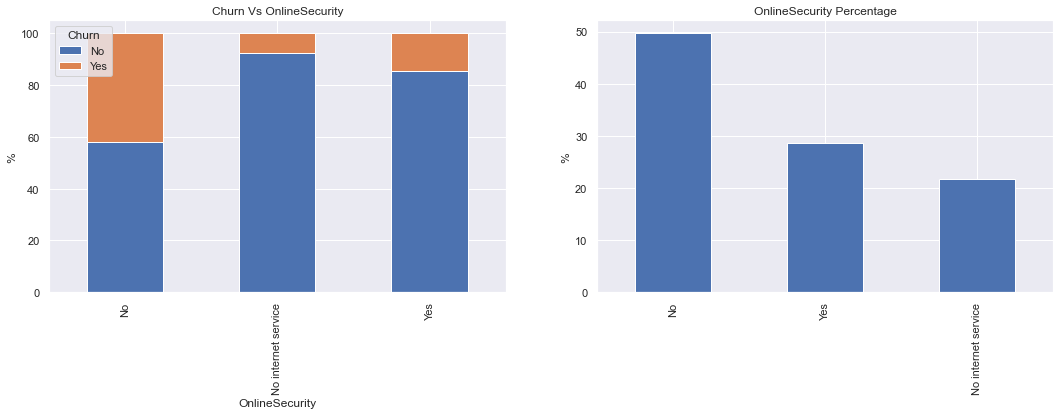

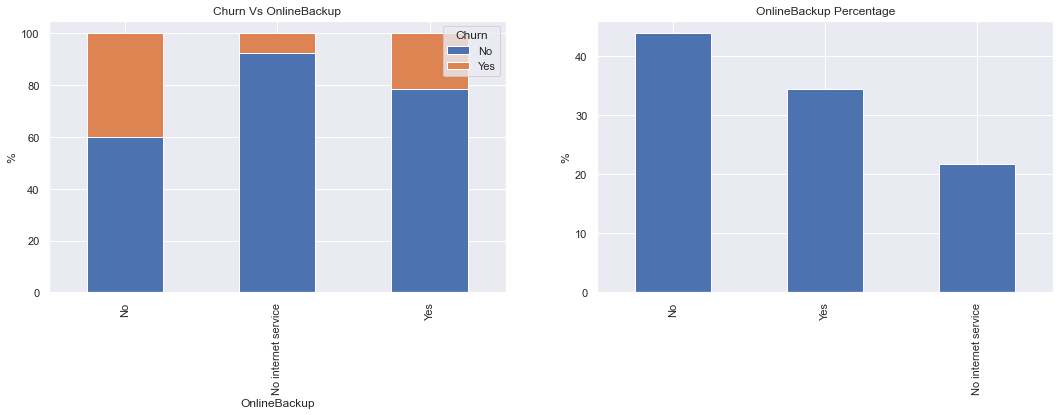

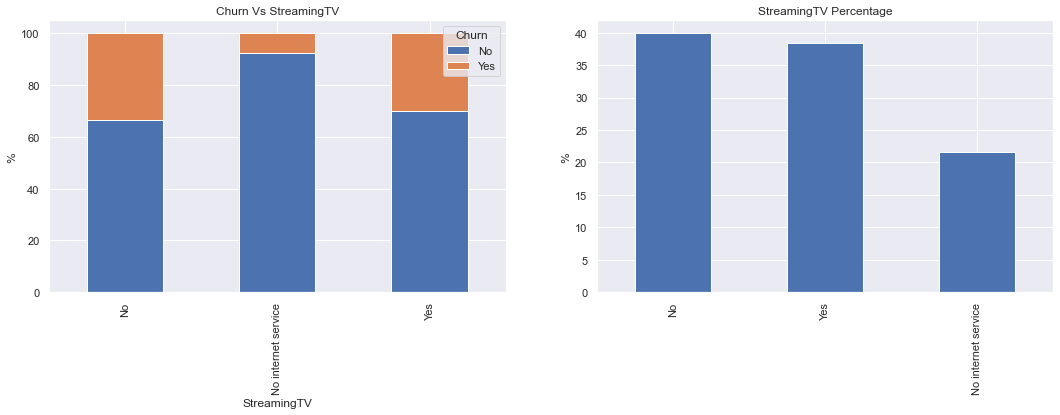

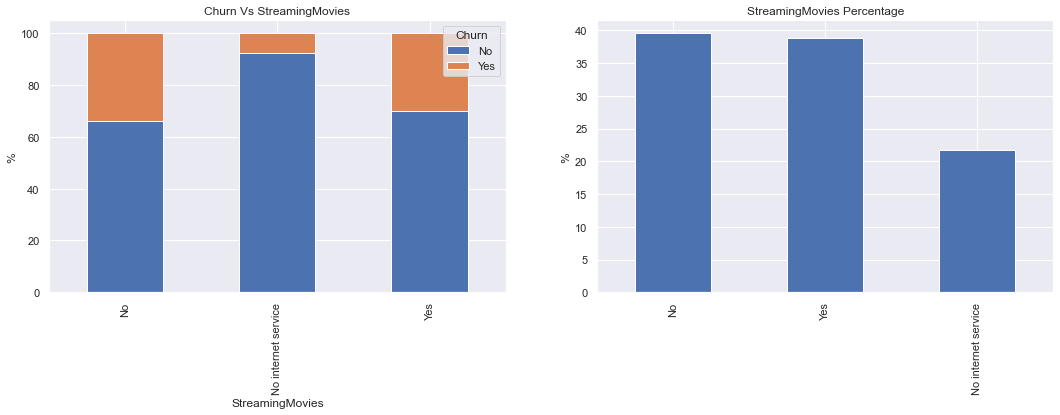

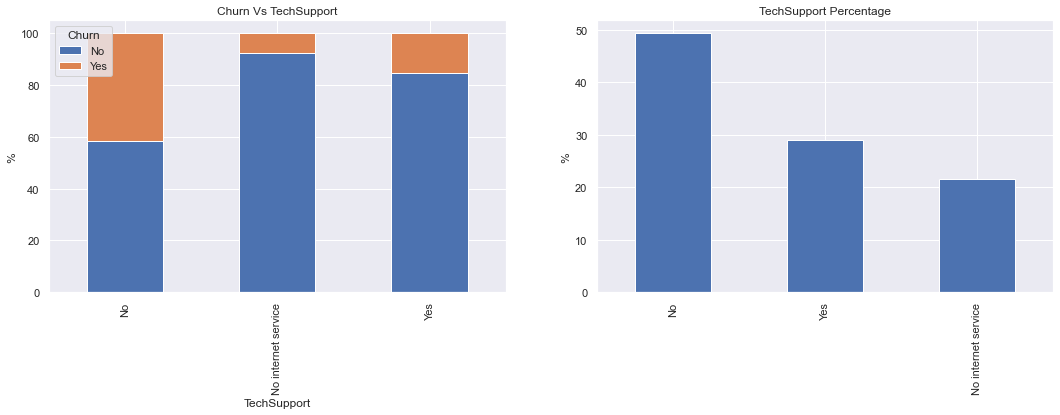

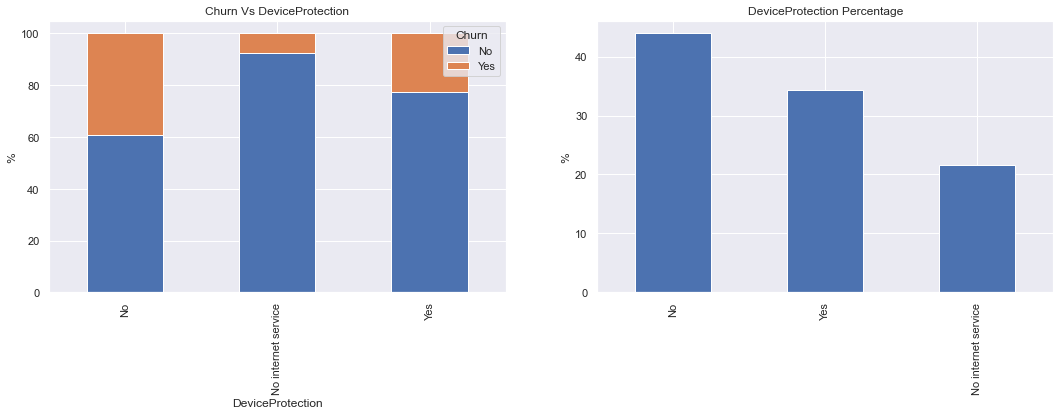

In [22]:
#Função para plotar gráficos Churn vs Coluna
def plot_churn(df,column):
    fig, ax = plt.subplots(1,2, figsize=(20,20))
    tmp1 = pd.crosstab(index = df[column], columns = df['Churn'], values = df['Churn'],
                               aggfunc = len,
                               normalize = 'index').mul(100)

    tmp2 = df[column].value_counts(normalize=True).mul(100)
    tmp1.plot.bar(stacked=True,figsize=(18,5),ax=ax[0], ylabel='%')
    tmp2.plot.bar(stacked=True,figsize=(18,5),ax=ax[1], ylabel='%')
    ax[1].set_title('{} Percentage'.format(column))
    ax[0].set_title('Churn Vs {}'.format(column))
    


#Churn por serviços
plot_churn(produtos,'PhoneService')
#Churn por Tipo de Serviço de Internet
plot_churn(df,'InternetService')
#Churn por serviço de internet
plot_churn(produtos,'InternetService')
#Churn por Tipo de Serviço de Internet
plot_churn(produtos,'TelefoneInternet')
#Churn por cliente que contrata servios de internet extras
plot_churn(produtos,'ContrataServiço')
#Churn por genêro
plot_churn(produtos,'gender')
#Churn por faixa de idade
plot_churn(produtos,'SeniorCitizen')
#Churn por situação marital
plot_churn(produtos,'Partner')
#Churn por dependentes
plot_churn(produtos,'Dependents')
#Churn por contratante de segurança online
plot_churn(produtos,'OnlineSecurity')
#Churn por contratante de backup online
plot_churn(produtos,'OnlineBackup')
#Churn por contratante de backup online
plot_churn(produtos,'StreamingTV')
#Churn por contratante de backup online
plot_churn(produtos,'StreamingMovies')
#Churn por contratante de backup online
plot_churn(produtos,'TechSupport')
#Churn por contratante de backup online
plot_churn(produtos,'DeviceProtection')


Novamente é possível de observar tendências bem interessantes no dados:

- Pessoas que contratam serviços de Internet extra tem uma taxa bem menor de Churn;
- Entre os assinantes de serviços de internet, os que mais deram churn foram os assinantes de Fibra Ótica;
- Clientes que só tem o serviço de telefone tem churn menor que clientes que tem ambos Telefone e Internet;
- O Churn é ligeiramente menor para assinantes de streamming TV e Filmes;
- O Churn é bem menor para clientes que assinam Suporte Tecnico e Segurança Online;
- Pessoas sem dependentes tem churn maior que as com dependentes.

Vamos agora começar a parte de implementação de modelos preditivos com uma arvore de decisão simples.

## Árvores de Decisão


O algoritmo de Árvore de decisão é um algortimo preditivo supervisionado, não parâmetrico, de Machine Learning, com estrutura hierarquica em forma de ávore com nó raiz, nós internos, galhos e folhas. O algoritmo visa criar uma sequência de segmentações binárias para alcançar a homogeniedade da variável resposta.

Para medir essa homogeniedade dentro das folhas é normalmente usado o indice Gini ou Entropia de Shannon, onde a impureza máxima é alcançada na distribuição uniforme e impureza mínima na concentração total.

O Algoritmo funciona deste modo:

1. Para cada variável, buscar a melhor regra binária
2. Escolher aplicar melhor segmentação dentre todas as variáveis
3. Recursivamente, para cada folha, repetir os passos 1 e 2 até que
uma regra de parada seja atingida

Após a criação de uma ávore podemos mudar os hiperparâmetros, que são parâmetros que controlam o algoritmo como:
1. Número mínimo de observações por folha
2. Profundidade máxima
3. CP – Custo de complexidade

E temos o nível de complexidade da árvore, que pode ser baixo, médio e alto.

Para cada variável vai ser criado um nó na árvore, com uma decisão binária, sendo que os primeiros nós são escolhidos de acordo com a variável que melhor consegue uma resposta homogenea daquele ponto.

As variáveis que vamos usar aqui para descobrir quem vai desistir dos serviços da empresa são:

- Gender: Genero biológico da pessoa (Homem ou Mulher)
- SeniorCitizen: Se a pessoa é idosa (0 para não 1 para sim)
- Partner: Se a pessoa tem um parceiro/a (0 para não 1 para sim)
- Dependents: Se a pessoa tem dependentes (Yes or No)
- PhoneService: Se a pessoa tem serviço de telefone ou não (Yes or No)
- Multiple Lines: Se a pessoa tem mais de uma linha (Yes, No or No Phone Service)
- Internet Service: Se a pessoa assina internet (DSL, Fiber Optic, No)
- OnlineSecurity: se ela assina o serviço de segurança online (Yes, No, No internet service)
- OnlineBackup: Se o cliente tem serviço de backup online (Yes, No, No internet service)
- DeviceProtection: Se o cliente tem proteção para seu dispositivo (Yes, No, No internet service)
- TechSupport: Se o cliente assina o suporte técnico (Yes, No, No internet service)
- StreamingTV: Se o cliente assina o serviço de streaming de TV (Yes, No, No internet service)
- StreamingMovies: Se o cliente assina o serviço de streaming de filmes (Yes, No, No internet service)
- Contract: Qual o tipo de contrato o cliente tem (mês a mês, um ano, dois anos)
- Paperless Billing: Se o cliente optou por faturas eletrônicas (Yes or No)
- PaymentMethod: Método de pagamento ('Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)')

E nossa variável alvo é:
- Churn: Se o cliente saiu da empresa ou não (Yes or No)

Primeiramente devemos separar nosso banco de dados entre treino e teste.
Esse passo é importante para sabermos se, de fato, nosso modelo vai funcionar em uma ocasião real.

0       No
1       No
2       No
3       No
4       No
        ..
7038    No
7039    No
7040    No
7041    No
7042    No
Name: Churn, Length: 7043, dtype: object
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.float64'>
<class 'numpy.float64'>


<ipython-input-9-bc134ecd0e53>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[column] = le.transform(X_train[column])
<ipython-input-9-bc134ecd0e53>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = le.transform(X_test[column])


O método de arvore de decisão teve um score de treino de:  72.0 % de acurácia
0.4993065187239944


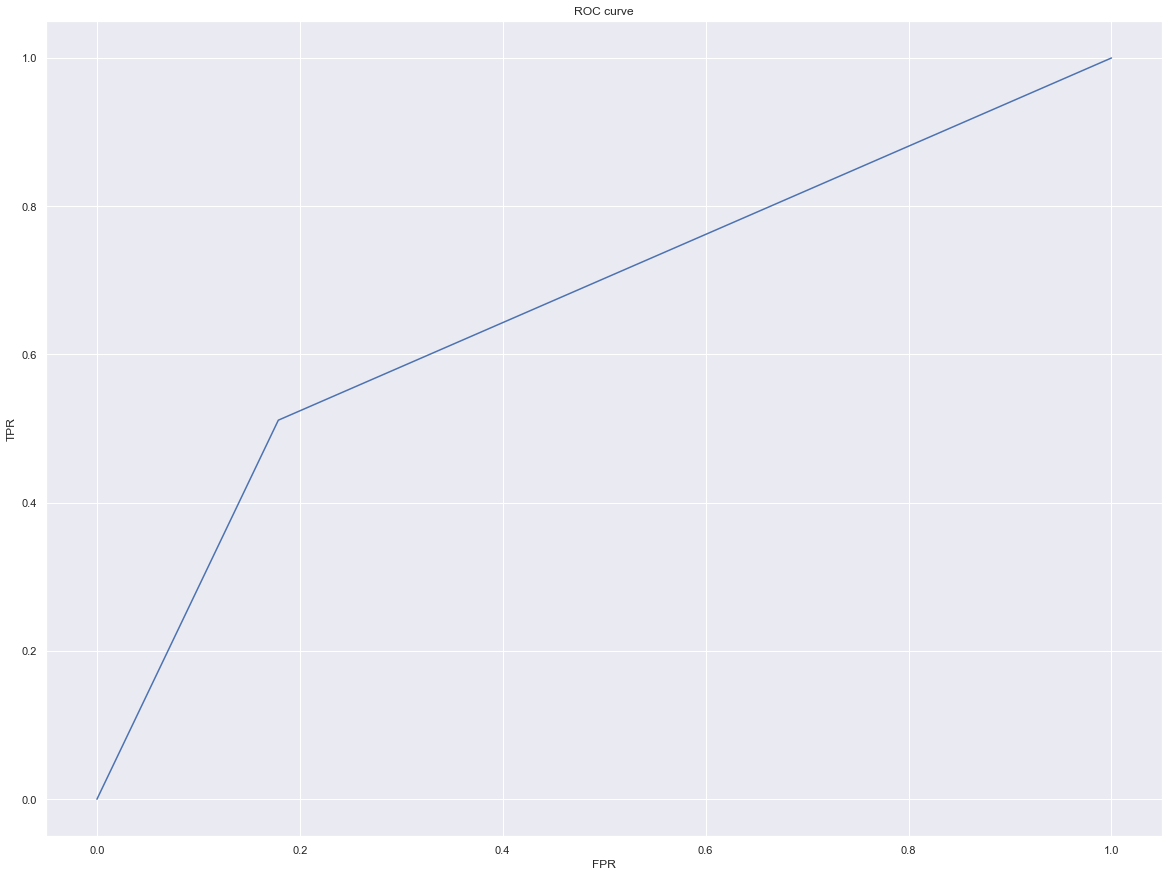

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

#Como esse algoritmo só funciona com float, vamos ter que fazer labels numericas.


X = df.drop(['Churn','customerID'], axis=1)
y = df['Churn']
print(y)
le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Trocar labels em strings por labels numéricas no train
for column in X_train:
    try:
        X_train[column].iloc[0].isnumeric() == False

    except AttributeError:
        print (type(X_train[column][0]))

    else:
        le = preprocessing.LabelEncoder()
        le.fit(X_train[column])
        X_train[column] = le.transform(X_train[column])


#Trocar labels em strings por labels numéricas no test
for column in X_test:
    try:
        X_test[column].iloc[1].isnumeric() == False

    except AttributeError:
        print (type(X_test[column][1]))

    else:
        le = preprocessing.LabelEncoder()
        le.fit(X_test[column])
        X_test[column] = le.transform(X_test[column])







#Vamos usar somente a arvore de decisão


avore_de_decisao = DecisionTreeClassifier(random_state=0)

avore_de_decisao.fit(X_train, y_train)

training_score = cross_val_score(avore_de_decisao, X_train, y_train, cv=5)
print("O método de arvore de decisão teve um score de treino de: ", round(training_score.mean(), 2) * 100, "% de acurácia e um F1-Score de:", f1_score(y_test, y_predicted))

y_predicted = avore_de_decisao.predict(X_test)

#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(avore_de_decisao,   
#                   class_names='Churn',
#                   filled=True)

fpr, tpr, _ = roc_curve(y_test, y_predicted)

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#confusion_matrix = pd.crosstab(y_test, y_predicted, rownames=['Actual'], colnames=['Predicted'])

#sns.heatmap(confusion_matrix, annot=True)
#plt.show()

#https://towardsdatascience.com/demystifying-roc-curves-df809474529a
 

## Ajustando os Hiperparâmetros

Agoravamos ajustar os hiperparâmetros da árvore para conseguirmos generalizar, evitando overfit, e conseguir os melhores resultados

O primeiro hiperparâmetro que vamos estudar é o max_depth, que indica o quão "profunda" uma árvore de decisão pode ir. Quanto mais profunda mais informação dos dados ela irá capturar, mas daí corremos o risco de fazer um modelo que vai muito bem nos dados de treino, mas ruim nos dados de validação ou teste. Isso se chama overfitting.

O próximo é o hiperparâmetro min_samples_split, esse hiperparâmetro especifica o número minimo de amostras necessárias para dividir um nó interno.

Outro hiperparâmetro é o min_samples_leaf, um nó folha, ou só folha, é um nó tem filhos, ou a saída de nossa árvore. Esse parâmetro é o número mínimo de amostras necessárias para ser uma folha.

E o último é o max_features, que representa o número de features, ou variáveis, levadas em conta quando procuramos pelo melhor "split". ele leva como entrada um inteiro para denotar o numero máximo de variáveis para para "split" ou porcentagem de variáveis para considerar quando se faz um split.

O critério que podemos usar é o índice Gini e entropia.


## Conclusões Da Análise


A maior lição que podemos tirar destes dados é que pessoas que contratam os serviços extra da empresa são menos propicias a sair do que pessoas que só contratam o serviço de internet.

também foi possível encontrar uma dispariedade de Churn entre pessoas que pagam com Electronic check e Mailed Check. Parece que pessoas que pagam com Electronic Check sairam mais dos serviços do que aqueles que pagam com Mailed Check.


Uma possível solução para mitigar o problema de churn da empresa é promover os serviços adicionais junto com o pacote de internet. Deste modo os clientes vão ter conhecimento destes serviços e podem contrata-los. A empresa também pode oferecer estes serviços de graça para pessoas que desejam cancelar a assinatura, garantindo-os como clientes.


Não podemos ignorar que a grande parte dos churn são de assinantes de fibra ótica. Será que temos algum problema com o serviço? Vale a pena investigar.